In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from community import community_louvain

import pycountry
import seaborn as sns

import collections
import jellyfish

import bs4 as bs  
import urllib.request  
import re  
import nltk

#from py_translator import Translator
from googletrans import Translator
from gensim.models import Word2Vec

# Importing the notebook with all the methods definition
import importlib
import GKG

import copy
import simplejson as json

In [2]:
switzerland_news = pd.read_csv('../CSV Files/switzerland_actors.csv', sep='\t', delimiter='\t', decimal = '.', error_bad_lines=False, 
                                  engine='c', encoding='latin-1')

In [9]:
dates = list(switzerland_news['V2.1DATE'])
np.min(dates), np.max(dates)

(20190407120000.0, 20190509233000.0)

In [3]:
# Extraction of the themes mentioned in the Tunisia Actor dataframe
theme_list = GKG.theme_list_extraction(switzerland_news)

In [4]:
tf_total, idf_total, tf_idf_total = GKG.tf_idf_computation(dataframe=switzerland_news, themes_of_interest=theme_list)

Num:  100889


In [ ]:
# Cleaning the idf dictionary to keep only the most common themes in the news
idf_total_clean = pd.DataFrame(columns=['theme'])
count = 0
for key, value in idf_total.items():
    if value > 300:
        for count_theme in range(0, value):
            idf_total_clean.loc[count]= key
            count += 1
            
descending_order = idf_total_clean['theme'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(8,9))
g = sns.countplot(y=idf_total_clean['theme'], order=descending_order)
g.set_ylabel('Themes')
g.set_title('Occurrences of themes in the Switzerland GDELT Dataframe')
plt.show()

In [5]:
# Actor network creation
G_actor = nx.Graph()
GKG.social_graph_creation(G_actor, switzerland_news)

list_actor = list(G_actor.nodes)
nodes_actor = len(list(G_actor.nodes))
edges_actor = len(list(G_actor.edges))
print("--- Switzerland News ---")
print("A total of %d actors have been detected" % nodes_actor)
print("A total of %d edges have been drawn" % edges_actor)


--- Switzerland News ---
A total of 7311 actors have been detected
A total of 34271 edges have been drawn


/Users/aminmekacher/miniconda3/envs/gdelt_project/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of the edge weight for the Swiss actor network')

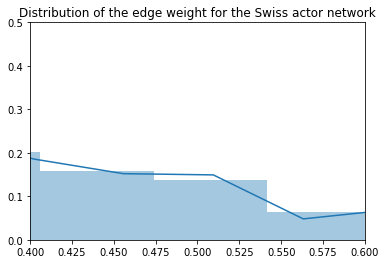

In [6]:
# Display of a histogram showing the distribution of the edge weight in the actor graph

edges_weight = nx.get_edge_attributes(G_actor, 'weight')
weight_list = []

for actor_edge in G_actor.edges:
    weight_list.append(edges_weight[actor_edge])

sns.distplot(weight_list, bins=100)
plt.ylim(0, 0.5)
plt.xlim(0.4, 0.6)
plt.title("Distribution of the edge weight for the Swiss actor network")

In [7]:
# Definition of an actor network with weak edges (weight < 0.72) removed

threshold_high = 1.5
G_actor_threshold_high = copy.deepcopy(G_actor)
G_actor_threshold_high = GKG.network_edge_filtering(graph=G_actor_threshold_high, threshold=threshold_high)

threshold_low = 0.45
G_actor_threshold_low = copy.deepcopy(G_actor)
G_actor_threshold_low = GKG.network_edge_filtering(graph=G_actor_threshold_low, threshold=threshold_low)

Removed edge:  34158
Removed nodes:  7172
Removed edge:  32989
Removed nodes:  6144


In [8]:
len(list(G_actor_threshold_high.nodes())), len(list(G_actor_threshold_low.nodes()))

(139, 1167)

In [9]:
# Computation of the page rank for each actor. This value is then assigned as an attribute

pagerank_actor = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor)
        
for actor in list(G_actor.nodes):
    G_actor.node[actor]['pageRank'] = float(pagerank_actor[actor])

# High Threshold

pagerank_actor_high = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor_threshold_high)
        
for actor in list(G_actor_threshold_high.nodes):
    G_actor_threshold_high.node[actor]['pageRank'] = float(pagerank_actor_high[actor])

# Low Threshold

pagerank_actor_low = nx.algorithms.link_analysis.pagerank_alg.pagerank(G_actor_threshold_low)
        
for actor in list(G_actor_threshold_low.nodes):
    G_actor_threshold_low.node[actor]['pageRank'] = float(pagerank_actor_low[actor])

In [10]:
# By using the PageRank attribute, we can extract the 10 most influential actors in the network

actor_dict = dict(G_actor.nodes)
sorted_actor_dict = dict(sorted(actor_dict.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor = GKG.topk_actor_extraction(sorted_actor_dict, k=10)

# High Threshold

actor_dict_high = dict(G_actor_threshold_high.nodes)
sorted_actor_dict_high = dict(sorted(actor_dict_high.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor_high = GKG.topk_actor_extraction(sorted_actor_dict_high, k=10)

# Low Threshold

actor_dict_low = dict(G_actor_threshold_low.nodes)
sorted_actor_dict_low = dict(sorted(actor_dict_low.items(), key = lambda x: x[1]['pageRank'], reverse=True))

topk_actor_low = GKG.topk_actor_extraction(sorted_actor_dict_low, k=10)

In [11]:
# Study of the cliques in the actor social network

partition = community_louvain.best_partition(G_actor)
for node_actor in list(G_actor.nodes):
    G_actor.node[node_actor]['community'] = partition[node_actor]

filepath_actor = '../Gephi Files/switzerland_news.gexf'
nx.write_gexf(G_actor, filepath_actor, version="1.2draft")

# High threshold

partition_high = community_louvain.best_partition(G_actor_threshold_high)
for node_actor in list(G_actor_threshold_high.nodes):
    G_actor_threshold_high.node[node_actor]['community'] = partition_high[node_actor]

filepath_actor_high = '../Gephi Files/switzerland_threshold_high.gexf'
nx.write_gexf(G_actor_threshold_high, filepath_actor_high, version="1.2draft")

# Low threshold

partition_low = community_louvain.best_partition(G_actor_threshold_low)
for node_actor in list(G_actor_threshold_low.nodes):
    G_actor_threshold_low.node[node_actor]['community'] = partition_low[node_actor]

filepath_actor_low = '../Gephi Files/switzerland_threshold_low.gexf'
nx.write_gexf(G_actor_threshold_low, filepath_actor_low, version="1.2draft")

In [41]:
# Save the tfidf dictionary in an external file

import simplejson as json

json_tfidf = json.dumps(tf_idf_total)
f = open("../JSON_files/switzerland_tfidf.json","w")
f.write(json_tfidf)
f.close()

In [4]:
with open('../JSON_files/switzerland_tfidf.json', 'r') as f:
    distros_dict = json.load(f)

In [14]:
GKG.save_to_json(G=G_actor_threshold_high, fname='../JSON_files/switzerland_news_threshold_high')
GKG.save_to_json(G=G_actor_threshold_low, fname='../JSON_files/switzerland_news_threshold_low')
GKG.save_to_json(G=G_actor, fname='../JSON_files/switzerland_news')

In [5]:
G_actor = GKG.load_json(fname='../JSON_files/switzerland_news_threshold_low')
list_actor = list(G_actor.nodes)
tf_idf_total = distros_dict

In [6]:
importlib.reload(GKG)

<module 'GKG' from '/Users/aminmekacher/Documents/EPFL Master/MA2/GDELT Project/GDELT-Project/Notebooks/GKG.py'>

In [7]:
# Theme network generation

G_themes = nx.Graph()
G_themes = nx.create_empty_copy(G_actor)
list_actor = list(G_themes.nodes)
GKG.theme_network_creation(G_themes, list_actor, switzerland_news, theme_list, tf_idf_total)

nodes_themes = len(list(G_themes.nodes)) - nodes_actor
edges_themes = len(list(G_themes.edges))
print("--- Switzerland Themes ---")
print("A total of %d themes have been detected" % nodes_themes)
print("A total of %d edges have been drawn" % edges_themes)

for theme in themes_of_interest:
    if G_themes.has_node(theme):
        G_themes.node[theme]['nodeType'] = 'Theme'
    
for node in list(G_themes.nodes):
    if node not in themes_of_interest:
        G_themes.node[node]['nodeType'] = 'Actor'

filepath_theme = '../Gephi Files/switzerland_themes.gexf'
nx.write_gexf(G_themes, filepath_theme, version='1.2draft')

NameError: name 'nodes_actor' is not defined

In [10]:
# Definition of a new graph, with only the most influential actors kept

G_influence = G_themes.copy()
nodes_to_remove = []

for node in G_influence.nodes:
    remove_node = node not in theme_list and node not in topk_actor
    #print("node: ", node, remove_node)
    
    if remove_node:
        nodes_to_remove.append(node)

G_influence.remove_nodes_from(nodes_to_remove)
G_influence.nodes

filepath_influence = '../Gephi Files/switzerland_influence.gexf'
nx.write_gexf(G_influence, filepath_influence, version='1.2draft')

NameError: name 'topk_actor' is not defined

In [14]:
strongest_themes = {}

for node in G_influence.nodes:
    if G_influence.node[node]['nodeType'] == 'Actor':
    
        theme_list = []
        weight_list = []

        strongest_themes[node] = {}
        edges = list(G_influence.edges(node, data=True))

        for edge in edges:
            theme_edge = edge[1]
            weight_edge = edge[2]['weight']

            theme_list.append(theme_edge)
            weight_list.append(weight_edge)
    
        index_themes = np.flip(np.argsort(weight_list))[0:5]
        
        print("--- ", node, " ---")
            
        print([theme_list[index] for index in index_themes])

---  Youssef Chahed  ---
['GENERAL_GOVERNMENT', 'LEADER', 'ELECTION', 'LEGISLATION', 'ALLIANCE']
---  Muhammad Karki  ---
['LEADER', 'GENERAL_GOVERNMENT', 'ELECTION', 'RELIGION', 'TERROR']
---  El Sebsi  ---
['LEADER', 'GENERAL_GOVERNMENT', 'ELECTION', 'BORDER', 'MEDIA_MSM']
---  Rashid Ghannouchi  ---
['LEADER', 'GENERAL_GOVERNMENT', 'ELECTION', 'ALLIANCE', 'BORDER']
---  Baji Kaid Essebsi  ---
['LEADER', 'GENERAL_GOVERNMENT', 'ELECTION', 'LEGISLATION', 'BORDER']
---  Ben Ali  ---
['LEADER', 'GENERAL_GOVERNMENT', 'LEGISLATION', 'TOURISM', 'RELIGION']
---  El Abidine Ben Ali  ---
['LEADER', 'GENERAL_GOVERNMENT', 'ELECTION', 'LEGISLATION', 'ALLIANCE']
---  Hafedh Essebssi  ---
['LEADER', 'GENERAL_GOVERNMENT', 'ELECTION', 'LEGISLATION', 'MEDIA_MSM']
---  Kanzler Saad Hariri  ---
['GENERAL_GOVERNMENT', 'LEADER', 'ELECTION', 'DEMOCRACY', 'RELIGION']
---  Kanzler Ali  ---
['GENERAL_GOVERNMENT', 'LEADER', 'ELECTION', 'MEDIA_MSM', 'TERROR']
